In [2]:
%%bash
pip install kaggle

  Running setup.py bdist_wheel for kaggle: started
  Running setup.py bdist_wheel for kaggle: finished with status 'done'
  Stored in directory: /home/ec2-user/.cache/pip/wheels/57/4e/e8/bb28d035162fb8f17f8ca5d42c3230e284c6aa565b42b72674
  Running setup.py bdist_wheel for python-slugify: started
  Running setup.py bdist_wheel for python-slugify: finished with status 'done'
  Stored in directory: /home/ec2-user/.cache/pip/wheels/11/94/81/312969455540cb0e6a773e5d68a73c14128bfdfd4a7969bb4f
Successfully built kaggle python-slugify


You are using pip version 10.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [4]:

%%bash
mkdir /home/ec2-user/.kaggle
mv /home/ec2-user/SageMaker/kaggle.json /home/ec2-user/.kaggle
chmod 600 /home/ec2-user/.kaggle/kaggle.json


In [5]:
%%bash
ls -al /home/ec2-user/.kaggle/

total 12
drwxrwxr-x  2 ec2-user ec2-user 4096 Nov  8 19:33 .
drwx------ 22 ec2-user ec2-user 4096 Nov  8 19:33 ..
-rw-------  1 ec2-user ec2-user   65 Nov  8 19:32 kaggle.json


Using Kaggle API to download the dataset

In [7]:

%%bash
kaggle datasets download --unzip paultimothymooney/breast-histopathology-images


100%|██████████| 3.10G/3.10G [01:40<00:00, 33.2MB/s]


Removing the directory after unzipping the files

In [8]:
%%bash
rm -rf IDC_regular_ps50_idx5

Creating two folders, 0 for no cancer detected images, and 1 for cancer detected images

In [9]:
%%bash
mkdir images/0
mkdir images/1

In [10]:
import os


Moving all the class0 images to 0 directory and class1 images to 1 directory

In [11]:
for path, subdirs, files in os.walk('images'):
    for name in files:
        filename = os.path.join(path,name)
        if name.endswith('class0.png'):
            destination_class = '0'
        else:
            destination_class = '1'
        os.rename(filename,os.path.join('images',destination_class,name))

In [ ]:
df = pd.df()

In [3]:
%%bash
cd images/0
ls -l|wc -l

198739


In [4]:
%%bash
cd images/1
ls -l|wc -l

78787


In [14]:
%%bash
shopt -s extglob
cd images
rm -rf !("0"|"1")

#Display an image with no cancer class - class0 

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

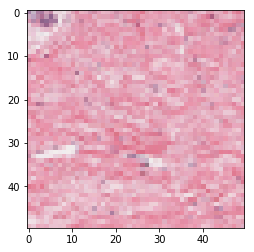

In [16]:
img = mpimg.imread('images/0/16551_idx5_x2651_y2001_class0.png')
imgplot = plt.imshow(img)
plt.show()

#Display an image with cancer (class 1)

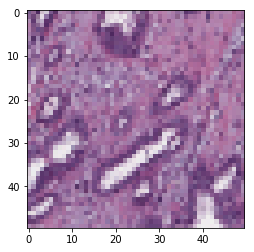

In [17]:
img = mpimg.imread('images/1/15516_idx5_x2101_y1751_class1.png')
imgplot = plt.imshow(img)
plt.show()

#Convert images to the RecordIO format and upload to S3
#Fetch the im2rec script from Apache MxNet Github Repo

In [18]:
%%bash
wget https://raw.githubusercontent.com/apache/incubator-mxnet/master/tools/im2rec.py
chmod +x im2rec.py

--2019-11-08 20:46:52--  https://raw.githubusercontent.com/apache/incubator-mxnet/master/tools/im2rec.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.200.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.200.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15838 (15K) [text/plain]
Saving to: ‘im2rec.py’

     0K .......... .....                                      100% 41.3M=0s

2019-11-08 20:46:52 (41.3 MB/s) - ‘im2rec.py’ saved [15838/15838]



#Create the .lst files needed for creating the .rec files for train and test datasets

In [19]:
%%bash

python im2rec.py --list --recursive --test-ratio 0.3 --train-ratio 0.7 images images/

0 0
1 1


#Create the .rec files for train and test datasets

In [20]:
%%bash

python im2rec.py --num-thread 4 --pass-through images_train.lst images
python im2rec.py --num-thread 4 --pass-through images_test.lst images

Creating .rec file from /home/ec2-user/SageMaker/images_train.lst in /home/ec2-user/SageMaker
time: 0.0012443065643310547  count: 0
time: 0.11862635612487793  count: 1000
time: 0.08197331428527832  count: 2000
time: 0.055518388748168945  count: 3000
time: 0.0630502700805664  count: 4000
time: 0.061373233795166016  count: 5000
time: 0.05242133140563965  count: 6000
time: 0.05972599983215332  count: 7000
time: 0.05711007118225098  count: 8000
time: 0.0468754768371582  count: 9000
time: 0.1516885757446289  count: 10000
time: 0.0456082820892334  count: 11000
time: 0.04671931266784668  count: 12000
time: 0.04296469688415527  count: 13000
time: 0.045619964599609375  count: 14000
time: 0.04415082931518555  count: 15000
time: 0.0475163459777832  count: 16000
time: 0.043305158615112305  count: 17000
time: 0.04607725143432617  count: 18000
time: 0.042839765548706055  count: 19000
time: 0.044181108474731445  count: 20000
time: 0.02471613883972168  count: 21000
time: 0.06429553031921387  count: 22

Uploading the train and test .rec files to S3

In [21]:
%%bash

aws s3 cp images_train.rec s3://sagemaker-gwu-capstone-2019/breast-cancer-detection/input/recordio/train/


upload: ./images_train.rec to s3://sagemaker-gwu-capstone-2019/breast-cancer-detection/input/recordio/train/images_train.rec


In [22]:
%%bash
aws s3 cp images_test.rec s3://sagemaker-gwu-capstone-2019/breast-cancer-detection/input/recordio/test/

upload: ./images_test.rec to s3://sagemaker-gwu-capstone-2019/breast-cancer-detection/input/recordio/test/images_test.rec
